Top Correlations:
                       Feature1                          Feature2  Correlation
700                   Superhost       host_is_superhost_in_period     1.000000
934      prev_host_is_superhost  prev_host_is_superhost_in_period     1.000000
4913    prev_numReserv_pastYear     prev_numReservedDays_pastYear     0.992690
4214   numReservedDays_pastYear     prev_numReservedDays_pastYear     0.992344
4448         numReserv_pastYear           prev_numReserv_pastYear     0.992103
...                         ...                               ...          ...
14273     zip_black_nothispanic             zip_white_nothispanic    -0.537495
8913                  Longitude    zip_hispanic_or_latino_anyrace    -0.592061
8682                   Latitude             zip_black_nothispanic    -0.617608
12869          tract_black_perc                  tract_white_perc    -0.658592
12643          tract_white_perc             zip_black_nothispanic    -0.678425

[27028 rows x 3 columns]


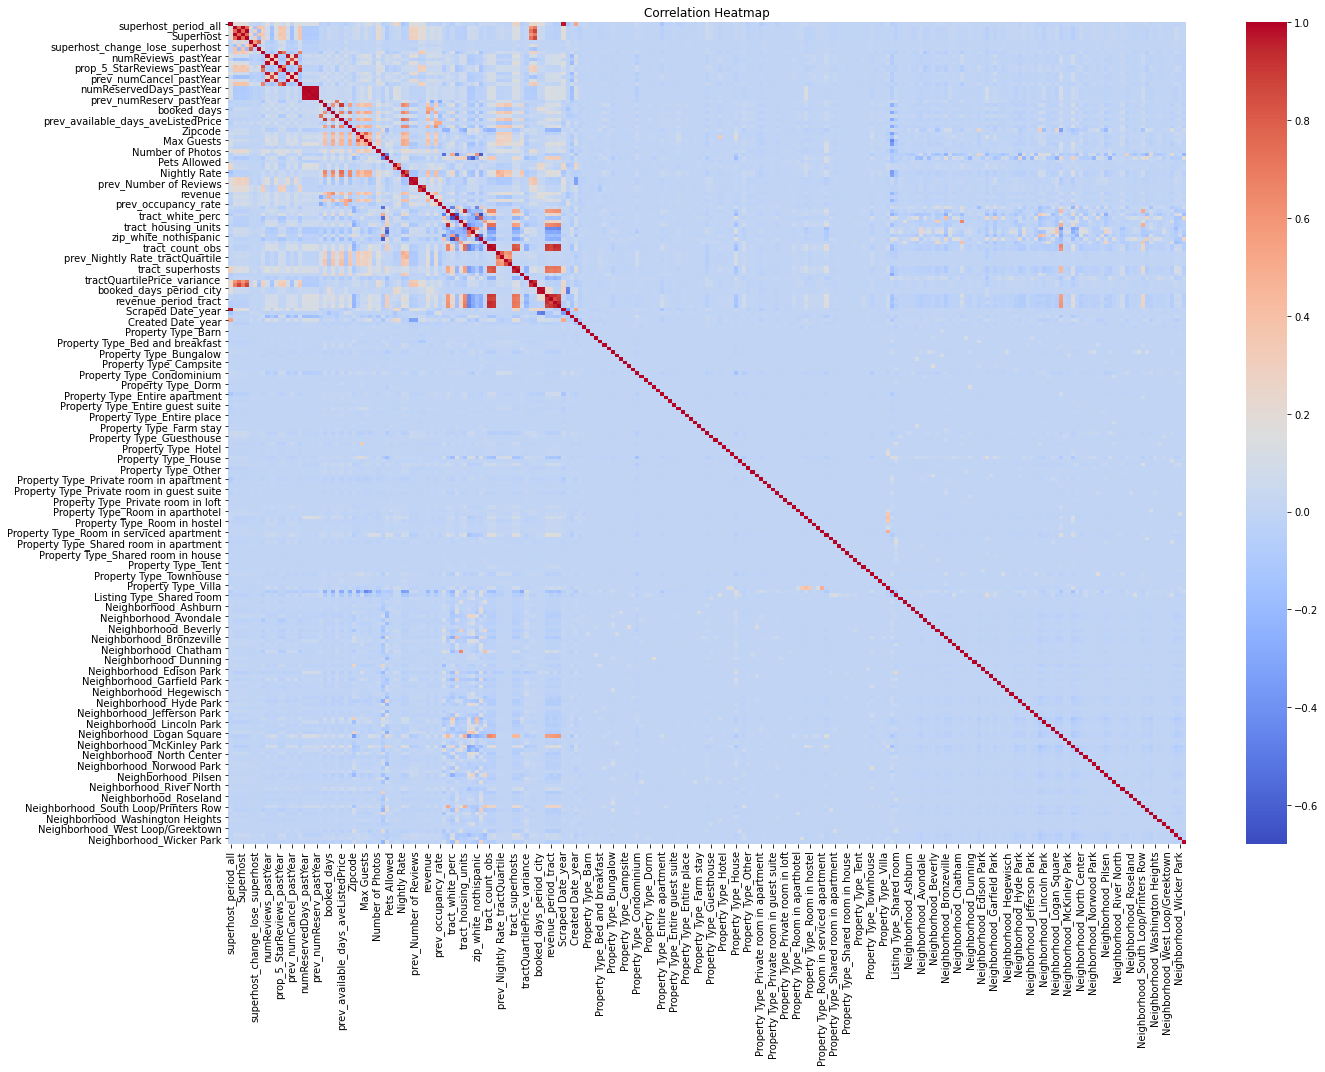

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# List of specified columns
cols = [
    "Airbnb Host ID", "Airbnb Property ID", "superhost_period_all", "Scraped Date", 
    "host_is_superhost_in_period", "prev_host_is_superhost_in_period", "Superhost", 
    "prev_host_is_superhost", "superhost_change", "superhost_change_lose_superhost", 
    "superhost_change_gain_superhost", "rating_ave_pastYear", "numReviews_pastYear", 
    "numCancel_pastYear", "num_5_star_Rev_pastYear", "prop_5_StarReviews_pastYear", 
    "prev_rating_ave_pastYear", "prev_numReviews_pastYear", "prev_numCancel_pastYear", 
    "prev_num_5_star_Rev_pastYear", "prev_prop_5_StarReviews_pastYear", "numReservedDays_pastYear", 
    "numReserv_pastYear", "prev_numReservedDays_pastYear", "prev_numReserv_pastYear", 
    "available_days", "available_days_aveListedPrice", "booked_days", "booked_days_avePrice", 
    "prev_available_days", "prev_available_days_aveListedPrice", "prev_booked_days", 
    "prev_booked_days_avePrice", "Property Type", "Listing Type", "Created Date", "Zipcode", 
    "Bedrooms", "Bathrooms", "Neighborhood", "Max Guests", "Cleaning Fee (USD)", "Minimum Stay", 
    "Number of Photos", "Latitude", "Longitude", "Pets Allowed", "Instantbook Enabled", 
    "prev_Instantbook Enabled", "Nightly Rate", "prev_Nightly Rate", "Number of Reviews", 
    "prev_Number of Reviews", "Rating Overall", "prev_Rating Overall", "revenue", "occupancy_rate", 
    "prev_revenue", "prev_occupancy_rate", "census_tract", "tract_total_pop", "tract_white_perc", 
    "tract_black_perc", "tract_asian_perc", "tract_housing_units", "zip_total_population", 
    "zip_hispanic_or_latino_anyrace", "zip_white_nothispanic", "zip_black_nothispanic", 
    "zip_asian_nothispanic", "tract_count_obs", "tract_unique_prices", "Nightly Rate_tractQuartile", 
    "prev_Nightly Rate_tractQuartile", "available_days_aveListedPrice_tractQuartile", 
    "prev_available_days_aveListedPrice_tractQuartile", "tract_superhosts", "tract_prev_superhosts", 
    "tract_price_variance", "tractQuartilePrice_variance", "prev_host_is_superhost1", 
    "prev_year_superhosts", "booked_days_period_city", "revenue_period_city", "booked_days_period_tract", 
    "revenue_period_tract", "tract_booking_share", "tract_revenue_share"
]

# Load data with specified columns only
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=cols)

# Drop ID columns since they're not useful for correlation or clustering
id_cols = ["Airbnb Host ID", "Airbnb Property ID"]
for c in id_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Convert date columns to datetime and extract numeric features
date_cols = []
if 'Scraped Date' in df.columns:
    date_cols.append('Scraped Date')
if 'Created Date' in df.columns:
    date_cols.append('Created Date')

for dcol in date_cols:
    df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
    df[dcol + '_year'] = df[dcol].dt.year
    df[dcol + '_month'] = df[dcol].dt.month
    df[dcol + '_day'] = df[dcol].dt.day
    df.drop(dcol, axis=1, inplace=True)

# Identify object columns for encoding
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert binary categorical columns that are TRUE/FALSE to 1/0
for col in object_cols:
    unique_vals = df[col].dropna().unique()
    # If column has TRUE/FALSE or True/False
    if set(str(val).upper() for val in unique_vals) == {'TRUE', 'FALSE'}:
        df[col] = df[col].map({'FALSE': 0, 'TRUE': 1, 'False':0, 'True':1})
        
# Update object columns after above conversions
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# For columns that are categorical with more than two categories, one-hot encode
if len(object_cols) > 0:
    # To avoid extremely large dimensionality, consider label encoding if categories are too numerous.
    # Here we do one-hot:
    df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# Fill missing values
for col in df.columns:
    if df[col].isnull().any():
        # Use median for numeric columns
        df[col].fillna(df[col].median(), inplace=True)

# Ensure all columns are numeric now
assert df.select_dtypes(include=['object']).empty, "There are still non-numeric columns."

# --- CORRELATION ANALYSIS ---
corr_matrix = df.corr()

# Print correlation values in a sorted manner
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
# Remove duplicates (corr is symmetric) and self-correlation (Feature1 == Feature2)
corr_pairs = corr_pairs[corr_pairs['Feature1'] < corr_pairs['Feature2']]
corr_pairs_sorted = corr_pairs.sort_values(by='Correlation', ascending=False)

print("Top Correlations:")
print(corr_pairs_sorted)

#print("\nTop 20 Negative Correlations:")
#print(corr_pairs_sorted.tail(20))

# Plot a heatmap (may be large)
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



In [11]:
# Assuming corr_pairs_sorted is the DataFrame containing the correlation data
# as derived from the previous code snippets

corr_pairs_sorted.to_csv('correlation_data.csv', index=False)

print("Correlation data successfully saved to 'correlation_data.csv'.")


Correlation data successfully saved to 'correlation_data.csv'.


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

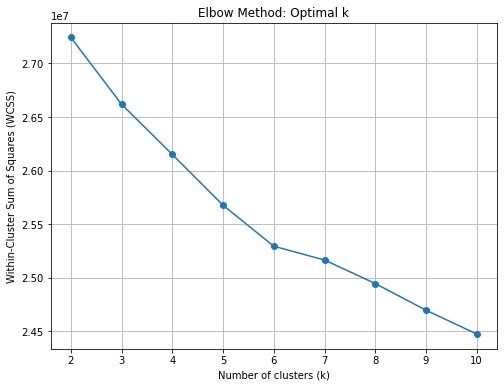

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster Means:
         superhost_period_all  host_is_superhost_in_period  \
cluster                                                      
0                   13.248957                     0.231775   
1                   14.233057                     0.906289   
2                   12.809637                     0.289100   
3                   12.096657                     0.094677   
4                   13.592869                     0.262932   

         prev_host_is_superhost_in_period  Superhost  prev_host_is_superhost  \
cluster                                                                        
0                                0.199392   0.231775                0.199392   
1                                0.982708   0.906289                0.982708   
2                                0.244427   0.289100                0.244427   
3                                0.010619   0.094677                0.010619   
4                                0.239842   0.262932                0

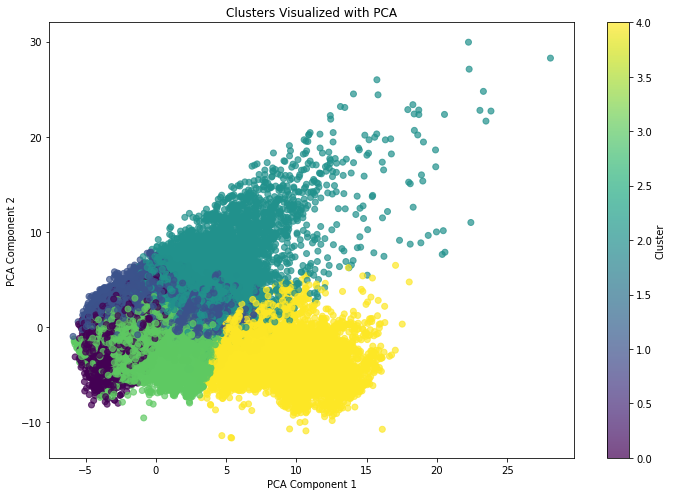

In [13]:
# --- CLUSTER ANALYSIS USING ELBOW METHOD ---
# We'll use all the numeric features for clustering
X = df.copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
K_values = range(2, 11)  # You can adjust this range as needed
for k in K_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,6))
plt.plot(K_values, wcss, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# After reviewing the plot, choose an appropriate k (example: k=5)
optimal_k = 5  # Replace this with the value you determine from the elbow curve

# Run KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

# Analyze cluster means
cluster_means = df.groupby('cluster').mean()
print("\nCluster Means:")
print(cluster_means)

cluster_means.to_csv('cluster.csv', index=False)
# --- VISUALIZE THE CLUSTERS ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


Superhost vs Non-Superhost Comparison
-------------------------------------
revenue: Superhosts mean=3249.55, Non-Superhosts mean=2693.40
occupancy_rate: Superhosts mean=0.16, Non-Superhosts mean=0.12
rating_ave_pastYear: Superhosts mean=4.88, Non-Superhosts mean=4.68
booked_days: Superhosts mean=26.51, Non-Superhosts mean=25.01
Nightly_Rate: Superhosts mean=150.43, Non-Superhosts mean=164.50

T-Test for Revenue: t=21.75, p=0.0000
T-Test for Occupancy Rate: t=39.19, p=0.0000

Regression Model Summary (Predicting Revenue):
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     9203.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:27:46   Log-Likelihood:            -1.1452e+0

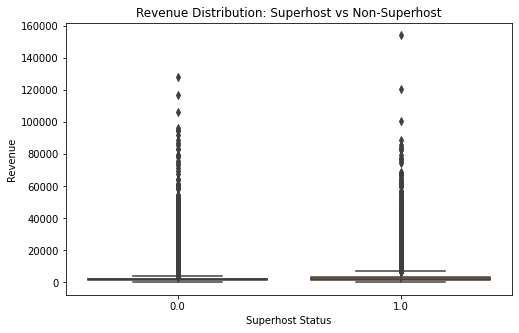

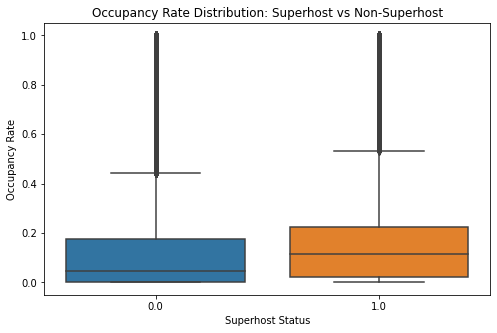

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder

# Columns to use
cols = [
    "Airbnb Host ID", "Airbnb Property ID", "superhost_period_all", "Scraped Date", 
    "host_is_superhost_in_period", "prev_host_is_superhost_in_period", "Superhost", 
    "prev_host_is_superhost", "superhost_change", "superhost_change_lose_superhost", 
    "superhost_change_gain_superhost", "rating_ave_pastYear", "numReviews_pastYear", 
    "numCancel_pastYear", "num_5_star_Rev_pastYear", "prop_5_StarReviews_pastYear", 
    "prev_rating_ave_pastYear", "prev_numReviews_pastYear", "prev_numCancel_pastYear", 
    "prev_num_5_star_Rev_pastYear", "prev_prop_5_StarReviews_pastYear", "numReservedDays_pastYear", 
    "numReserv_pastYear", "prev_numReservedDays_pastYear", "prev_numReserv_pastYear", 
    "available_days", "available_days_aveListedPrice", "booked_days", "booked_days_avePrice", 
    "prev_available_days", "prev_available_days_aveListedPrice", "prev_booked_days", 
    "prev_booked_days_avePrice", "Property Type", "Listing Type", "Created Date", "Zipcode", 
    "Bedrooms", "Bathrooms", "Neighborhood", "Max Guests", "Cleaning Fee (USD)", "Minimum Stay", 
    "Number of Photos", "Latitude", "Longitude", "Pets Allowed", "Instantbook Enabled", 
    "prev_Instantbook Enabled", "Nightly Rate", "prev_Nightly Rate", "Number of Reviews", 
    "prev_Number of Reviews", "Rating Overall", "prev_Rating Overall", "revenue", "occupancy_rate", 
    "prev_revenue", "prev_occupancy_rate", "census_tract", "tract_total_pop", "tract_white_perc", 
    "tract_black_perc", "tract_asian_perc", "tract_housing_units", "zip_total_population", 
    "zip_hispanic_or_latino_anyrace", "zip_white_nothispanic", "zip_black_nothispanic", 
    "zip_asian_nothispanic", "tract_count_obs", "tract_unique_prices", "Nightly Rate_tractQuartile", 
    "prev_Nightly Rate_tractQuartile", "available_days_aveListedPrice_tractQuartile", 
    "prev_available_days_aveListedPrice_tractQuartile", "tract_superhosts", "tract_prev_superhosts", 
    "tract_price_variance", "tractQuartilePrice_variance", "prev_host_is_superhost1", 
    "prev_year_superhosts", "booked_days_period_city", "revenue_period_city", 
    "booked_days_period_tract", "revenue_period_tract", "tract_booking_share", "tract_revenue_share"
]

# Load the dataset
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=cols)

# Convert date columns to datetime and extract numeric features
for dcol in ['Scraped Date', 'Created Date']:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
        df[dcol+'_year'] = df[dcol].dt.year
        df[dcol+'_month'] = df[dcol].dt.month
        df[dcol+'_day'] = df[dcol].dt.day
        df.drop(dcol, axis=1, inplace=True)

# Rename columns to remove spaces and special characters to avoid Patsy syntax issues
df.columns = (df.columns
                .str.replace(' ', '_')
                .str.replace('(', '', regex=False)
                .str.replace(')', '', regex=False))

# After renaming, for example:
# "Nightly Rate" -> "Nightly_Rate"
# "Number of Reviews" -> "Number_of_Reviews"
# "Property Type" -> "Property_Type", etc.

# Convert TRUE/FALSE binary columns to 0/1 if any
for col in df.select_dtypes(include='object').columns:
    unique_vals = df[col].dropna().unique()
    if set(str(val).upper() for val in unique_vals) == {'TRUE', 'FALSE'}:
        df[col] = df[col].map({'FALSE':0, 'TRUE':1, 'False':0, 'True':1})

# For remaining object columns, use Label Encoding
obj_cols = df.select_dtypes(include='object').columns.tolist()
for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Fill missing values
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Determine superhost column (after renaming, "host_is_superhost_in_period" should now be "host_is_superhost_in_period" unchanged)
if 'host_is_superhost_in_period' in df.columns:
    superhost_col = 'host_is_superhost_in_period'
else:
    superhost_col = 'Superhost'  # fallback if needed

# Descriptive comparison
print("Superhost vs Non-Superhost Comparison")
print("-------------------------------------")

metrics = ['revenue', 'occupancy_rate', 'rating_ave_pastYear', 'booked_days', 'Nightly_Rate']
metrics = [m for m in metrics if m in df.columns]

for m in metrics:
    if df[superhost_col].isin([0,1]).all():
        superhost_mean = df.loc[df[superhost_col]==1, m].mean()
        non_superhost_mean = df.loc[df[superhost_col]==0, m].mean()
        print(f"{m}: Superhosts mean={superhost_mean:.2f}, Non-Superhosts mean={non_superhost_mean:.2f}")

# T-test for revenue
if 'revenue' in df.columns and df[superhost_col].isin([0,1]).all():
    t_stat_rev, p_val_rev = ttest_ind(df.loc[df[superhost_col]==1, 'revenue'], 
                                      df.loc[df[superhost_col]==0, 'revenue'], equal_var=False)
    print(f"\nT-Test for Revenue: t={t_stat_rev:.2f}, p={p_val_rev:.4f}")

# T-test for occupancy_rate
if 'occupancy_rate' in df.columns and df[superhost_col].isin([0,1]).all():
    t_stat_occ, p_val_occ = ttest_ind(df.loc[df[superhost_col]==1, 'occupancy_rate'], 
                                      df.loc[df[superhost_col]==0, 'occupancy_rate'], equal_var=False)
    print(f"T-Test for Occupancy Rate: t={t_stat_occ:.2f}, p={p_val_occ:.4f}")

# Regression analysis
# Choose predictors. Ensure they exist with updated column names:
predictors = [superhost_col, 'rating_ave_pastYear', 'Number_of_Reviews', 'Nightly_Rate', 'occupancy_rate']
predictors = [p for p in predictors if p in df.columns and p != 'revenue']

if 'revenue' in df.columns and len(predictors) > 1:
    formula = "revenue ~ " + " + ".join(predictors)
    model = ols(formula, data=df).fit()
    print("\nRegression Model Summary (Predicting Revenue):")
    print(model.summary())

if 'occupancy_rate' in df.columns and len(predictors) > 1:
    formula_occ = "occupancy_rate ~ " + " + ".join(predictors)
    model_occ = ols(formula_occ, data=df).fit()
    print("\nRegression Model Summary (Predicting Occupancy Rate):")
    print(model_occ.summary())

# Visualization: Boxplots
if 'revenue' in df.columns and df[superhost_col].isin([0,1]).all():
    plt.figure(figsize=(8,5))
    sns.boxplot(x=superhost_col, y='revenue', data=df)
    plt.title('Revenue Distribution: Superhost vs Non-Superhost')
    plt.xlabel('Superhost Status')
    plt.ylabel('Revenue')
    plt.show()

if 'occupancy_rate' in df.columns and df[superhost_col].isin([0,1]).all():
    plt.figure(figsize=(8,5))
    sns.boxplot(x=superhost_col, y='occupancy_rate', data=df)
    plt.title('Occupancy Rate Distribution: Superhost vs Non-Superhost')
    plt.xlabel('Superhost Status')
    plt.ylabel('Occupancy Rate')
    plt.show()


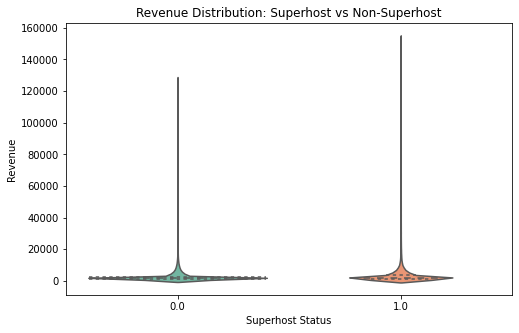

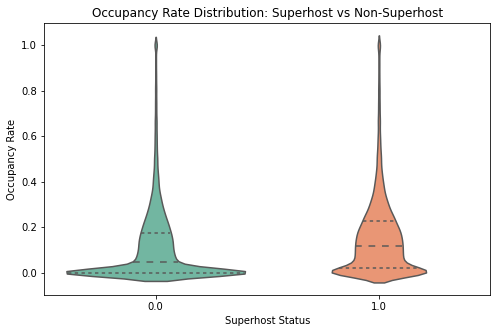

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for revenue
if 'revenue' in df.columns and df[superhost_col].isin([0,1]).all():
    plt.figure(figsize=(8,5))
    sns.violinplot(x=superhost_col, y='revenue', data=df, inner='quartile', palette='Set2')
    plt.title('Revenue Distribution: Superhost vs Non-Superhost')
    plt.xlabel('Superhost Status')
    plt.ylabel('Revenue')
    plt.show()

# Violin plot for occupancy_rate
if 'occupancy_rate' in df.columns and df[superhost_col].isin([0,1]).all():
    plt.figure(figsize=(8,5))
    sns.violinplot(x=superhost_col, y='occupancy_rate', data=df, inner='quartile', palette='Set2')
    plt.title('Occupancy Rate Distribution: Superhost vs Non-Superhost')
    plt.xlabel('Superhost Status')
    plt.ylabel('Occupancy Rate')
    plt.show()


Model R^2 Score: 0.7577
Model RMSE: 0.0856

Top 20 Features Influencing Occupancy Rate:
                               feature  importance
49                             revenue    0.163320
23                booked_days_avePrice    0.108660
24                 prev_available_days    0.060733
82                  Scraped Date_month    0.040233
25  prev_available_days_aveListedPrice    0.037014
51                 prev_occupancy_rate    0.036054
44                   prev_Nightly Rate    0.024059
42            prev_Instantbook Enabled    0.023925
27           prev_booked_days_avePrice    0.015881
36                        Minimum Stay    0.015014
29                        Listing Type    0.012218
46              prev_Number of Reviews    0.011555
22       available_days_aveListedPrice    0.011526
31                            Bedrooms    0.011114
14            prev_numReviews_pastYear    0.010400
43                        Nightly Rate    0.009852
7      superhost_change_gain_superhost    0.0

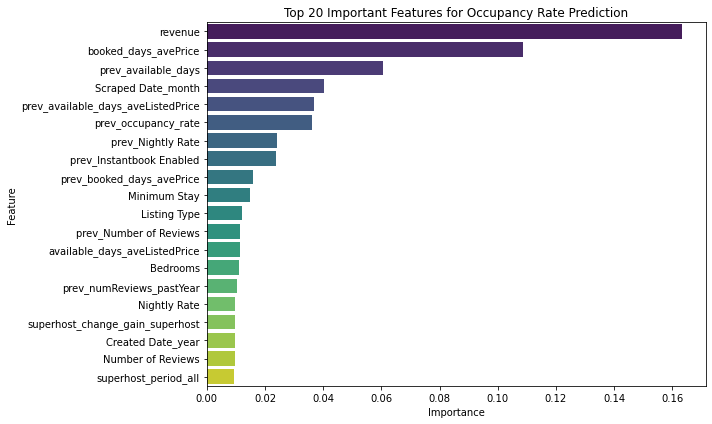

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Columns to use
cols = [
    "Airbnb Host ID", "Airbnb Property ID", "superhost_period_all", "Scraped Date", 
    "host_is_superhost_in_period", "prev_host_is_superhost_in_period", "Superhost", 
    "prev_host_is_superhost", "superhost_change", "superhost_change_lose_superhost", 
    "superhost_change_gain_superhost", "rating_ave_pastYear", "numReviews_pastYear", 
    "numCancel_pastYear", "num_5_star_Rev_pastYear", "prop_5_StarReviews_pastYear", 
    "prev_rating_ave_pastYear", "prev_numReviews_pastYear", "prev_numCancel_pastYear", 
    "prev_num_5_star_Rev_pastYear", "prev_prop_5_StarReviews_pastYear", "numReservedDays_pastYear", 
    "numReserv_pastYear", "prev_numReservedDays_pastYear", "prev_numReserv_pastYear", 
    "available_days", "available_days_aveListedPrice", "booked_days", "booked_days_avePrice", 
    "prev_available_days", "prev_available_days_aveListedPrice", "prev_booked_days", 
    "prev_booked_days_avePrice", "Property Type", "Listing Type", "Created Date", "Zipcode", 
    "Bedrooms", "Bathrooms", "Neighborhood", "Max Guests", "Cleaning Fee (USD)", "Minimum Stay", 
    "Number of Photos", "Latitude", "Longitude", "Pets Allowed", "Instantbook Enabled", 
    "prev_Instantbook Enabled", "Nightly Rate", "prev_Nightly Rate", "Number of Reviews", 
    "prev_Number of Reviews", "Rating Overall", "prev_Rating Overall", "revenue", "occupancy_rate", 
    "prev_revenue", "prev_occupancy_rate", "census_tract", "tract_total_pop", "tract_white_perc", 
    "tract_black_perc", "tract_asian_perc", "tract_housing_units", "zip_total_population", 
    "zip_hispanic_or_latino_anyrace", "zip_white_nothispanic", "zip_black_nothispanic", 
    "zip_asian_nothispanic", "tract_count_obs", "tract_unique_prices", "Nightly Rate_tractQuartile", 
    "prev_Nightly Rate_tractQuartile", "available_days_aveListedPrice_tractQuartile", 
    "prev_available_days_aveListedPrice_tractQuartile", "tract_superhosts", "tract_prev_superhosts", 
    "tract_price_variance", "tractQuartilePrice_variance", "prev_host_is_superhost1", 
    "prev_year_superhosts", "booked_days_period_city", "revenue_period_city", 
    "booked_days_period_tract", "revenue_period_tract", "tract_booking_share", "tract_revenue_share"
]

# Load the dataset
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=cols)

# Convert date columns to datetime and extract numeric features
for dcol in ['Scraped Date', 'Created Date']:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
        df[dcol+'_year'] = df[dcol].dt.year
        df[dcol+'_month'] = df[dcol].dt.month
        df[dcol+'_day'] = df[dcol].dt.day
        df.drop(dcol, axis=1, inplace=True)

# Encode binary columns if any
for col in df.select_dtypes(include='object').columns:
    unique_vals = df[col].dropna().unique()
    if set(str(v).upper() for v in unique_vals) == {'TRUE','FALSE'}:
        df[col] = df[col].map({'FALSE':0,'TRUE':1,'False':0,'True':1})

# Label encode remaining object columns
obj_cols = df.select_dtypes(include='object').columns
for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Fill missing values with median
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Drop ID columns (not useful for modeling)
id_cols = ['Airbnb Host ID', 'Airbnb Property ID']
for c in id_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Define target and features
if 'occupancy_rate' not in df.columns:
    raise ValueError("occupancy_rate column not found")

y = df['occupancy_rate']

# Remove features that directly cause leakage
# booked_days and available_days directly determine occupancy_rate = booked_days/available_days
leakage_features = ['booked_days', 'available_days']
for f in leakage_features:
    if f in df.columns:
        df.drop(f, axis=1, inplace=True)

X = df.drop('occupancy_rate', axis=1)

# Outlier filtration (optional)
# Ensure occupancy_rate is between 0 and 1
mask = (y >= 0) & (y <= 1)
X = X[mask]
y = y[mask]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model R^2 Score: {r2:.4f}")
print(f"Model RMSE: {rmse:.4f}")

# Feature Importance
feature_importances = model.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

print("\nTop 20 Features Influencing Occupancy Rate:")
print(imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp_df.head(20), palette='viridis')
plt.title('Top 20 Important Features for Occupancy Rate Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Model R^2 Score: 0.9979
Model RMSE: 116.4422

Top 20 Features Influencing Revenue:
                               feature  importance
24                         booked_days    0.464767
25                booked_days_avePrice    0.448217
51                      occupancy_rate    0.014963
27  prev_available_days_aveListedPrice    0.011996
23       available_days_aveListedPrice    0.005985
34                           Bathrooms    0.003155
79            booked_days_period_tract    0.002616
81                 tract_booking_share    0.002179
63               zip_black_nothispanic    0.001385
58                    tract_asian_perc    0.001385
82                 tract_revenue_share    0.001317
55                     tract_total_pop    0.001280
43                 Instantbook Enabled    0.001230
72               tract_prev_superhosts    0.001230
59                 tract_housing_units    0.001129
77             booked_days_period_city    0.001113
20       prev_numReservedDays_pastYear    0.001112

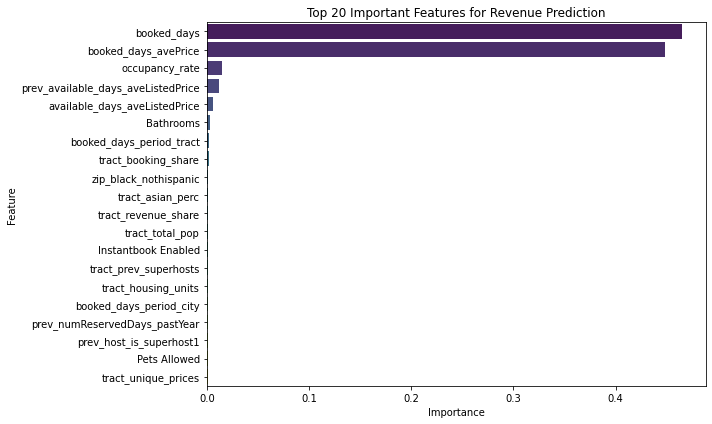

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Specify the columns you want to include. Here, we assume you want to include as many features as you have.
# If you already know the columns used previously, include them here.
# Below is the same large set used previously. Adjust if you want more or fewer columns.
cols = [
    "Airbnb Host ID", "Airbnb Property ID", "superhost_period_all", "Scraped Date", 
    "host_is_superhost_in_period", "prev_host_is_superhost_in_period", "Superhost", 
    "prev_host_is_superhost", "superhost_change", "superhost_change_lose_superhost", 
    "superhost_change_gain_superhost", "rating_ave_pastYear", "numReviews_pastYear", 
    "numCancel_pastYear", "num_5_star_Rev_pastYear", "prop_5_StarReviews_pastYear", 
    "prev_rating_ave_pastYear", "prev_numReviews_pastYear", "prev_numCancel_pastYear", 
    "prev_num_5_star_Rev_pastYear", "prev_prop_5_StarReviews_pastYear", "numReservedDays_pastYear", 
    "numReserv_pastYear", "prev_numReservedDays_pastYear", "prev_numReserv_pastYear", 
    "available_days", "available_days_aveListedPrice", "booked_days", "booked_days_avePrice", 
    "prev_available_days", "prev_available_days_aveListedPrice", "prev_booked_days", 
    "prev_booked_days_avePrice", "Property Type", "Listing Type", "Created Date", "Zipcode", 
    "Bedrooms", "Bathrooms", "Neighborhood", "Max Guests", "Cleaning Fee (USD)", "Minimum Stay", 
    "Number of Photos", "Latitude", "Longitude", "Pets Allowed", "Instantbook Enabled", 
    "prev_Instantbook Enabled", "Nightly Rate", "prev_Nightly Rate", "Number of Reviews", 
    "prev_Number of Reviews", "Rating Overall", "prev_Rating Overall", "revenue", "occupancy_rate", 
    "prev_revenue", "prev_occupancy_rate", "census_tract", "tract_total_pop", "tract_white_perc", 
    "tract_black_perc", "tract_asian_perc", "tract_housing_units", "zip_total_population", 
    "zip_hispanic_or_latino_anyrace", "zip_white_nothispanic", "zip_black_nothispanic", 
    "zip_asian_nothispanic", "tract_count_obs", "tract_unique_prices", "Nightly Rate_tractQuartile", 
    "prev_Nightly Rate_tractQuartile", "available_days_aveListedPrice_tractQuartile", 
    "prev_available_days_aveListedPrice_tractQuartile", "tract_superhosts", "tract_prev_superhosts", 
    "tract_price_variance", "tractQuartilePrice_variance", "prev_host_is_superhost1", 
    "prev_year_superhosts", "booked_days_period_city", "revenue_period_city", 
    "booked_days_period_tract", "revenue_period_tract", "tract_booking_share", "tract_revenue_share"
]

# Load the dataset
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=cols)

# Convert date columns to datetime and extract numeric features
for dcol in ['Scraped Date', 'Created Date']:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
        df[dcol+'_year'] = df[dcol].dt.year
        df[dcol+'_month'] = df[dcol].dt.month
        df[dcol+'_day'] = df[dcol].dt.day
        df.drop(dcol, axis=1, inplace=True)

# Encode binary columns if any
for col in df.select_dtypes(include='object').columns:
    unique_vals = df[col].dropna().unique()
    if set(str(v).upper() for v in unique_vals) == {'TRUE','FALSE'}:
        df[col] = df[col].map({'FALSE':0,'TRUE':1,'False':0,'True':1})

# Label encode remaining object columns
obj_cols = df.select_dtypes(include='object').columns
for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Fill missing values with median
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Drop ID columns (not useful for modeling)
id_cols = ['Airbnb Host ID', 'Airbnb Property ID']
for c in id_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Define target and features
target = 'revenue'
if target not in df.columns:
    raise ValueError(f"{target} column not found in the dataset")

y = df[target]
X = df.drop(target, axis=1)

# Outlier filtration (optional)
# For revenue, you might remove extremely high or low outliers if necessary.
# Example: remove top 1% of revenue values (optional)
upper_limit = y.quantile(0.99)
lower_limit = y.quantile(0.01)
mask = (y >= lower_limit) & (y <= upper_limit)
X = X[mask]
y = y[mask]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train XGBoost model to predict revenue
model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model R^2 Score: {r2:.4f}")
print(f"Model RMSE: {rmse:.4f}")

# Feature Importance
feature_importances = model.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

print("\nTop 20 Features Influencing Revenue:")
print(imp_df.head(20))

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp_df.head(20), palette='viridis')
plt.title('Top 20 Important Features for Revenue Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Model R^2 Score: 0.9600
Model RMSE: 507.9786

Top 20 Features Influencing Revenue After Removing Leakage:
                               feature  importance
25  prev_available_days_aveListedPrice    0.239996
49                      occupancy_rate    0.193061
23       available_days_aveListedPrice    0.167982
22                      available_days    0.150536
27           prev_booked_days_avePrice    0.021830
76                 revenue_period_city    0.015887
34                          Max Guests    0.013030
24                 prev_available_days    0.009742
29                        Listing Type    0.008023
82                  Scraped Date_month    0.007912
75             booked_days_period_city    0.007383
78                revenue_period_tract    0.006037
43                        Nightly Rate    0.005785
73             prev_host_is_superhost1    0.005187
35                  Cleaning Fee (USD)    0.004632
21             prev_numReserv_pastYear    0.004519
31                         

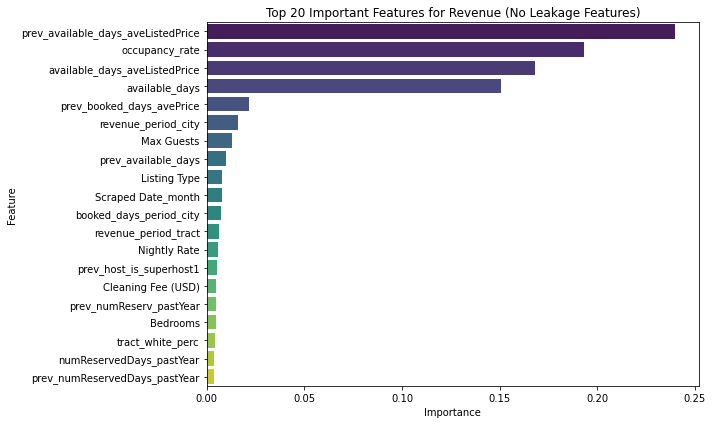


Descriptive Statistics of Significant Features:
       prev_available_days_aveListedPrice  occupancy_rate  \
count                       117731.000000   117731.000000   
mean                           132.334705        0.129601   
std                            135.120408        0.171677   
min                              0.000000        0.000000   
25%                             66.910090        0.000000   
50%                            109.502146        0.072165   
75%                            149.000000        0.194030   
max                           9000.000000        1.000000   

       available_days_aveListedPrice  available_days  \
count                  117731.000000   117731.000000   
mean                      134.478067      156.237906   
std                       152.831834       64.778158   
min                         0.000000        1.000000   
25%                        68.437197      121.000000   
50%                       113.184466      159.000000   
75%      

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Columns to use (same as before)
cols = [
    "Airbnb Host ID", "Airbnb Property ID", "superhost_period_all", "Scraped Date", 
    "host_is_superhost_in_period", "prev_host_is_superhost_in_period", "Superhost", 
    "prev_host_is_superhost", "superhost_change", "superhost_change_lose_superhost", 
    "superhost_change_gain_superhost", "rating_ave_pastYear", "numReviews_pastYear", 
    "numCancel_pastYear", "num_5_star_Rev_pastYear", "prop_5_StarReviews_pastYear", 
    "prev_rating_ave_pastYear", "prev_numReviews_pastYear", "prev_numCancel_pastYear", 
    "prev_num_5_star_Rev_pastYear", "prev_prop_5_StarReviews_pastYear", "numReservedDays_pastYear", 
    "numReserv_pastYear", "prev_numReservedDays_pastYear", "prev_numReserv_pastYear", 
    "available_days", "available_days_aveListedPrice", "booked_days", "booked_days_avePrice", 
    "prev_available_days", "prev_available_days_aveListedPrice", "prev_booked_days", 
    "prev_booked_days_avePrice", "Property Type", "Listing Type", "Created Date", "Zipcode", 
    "Bedrooms", "Bathrooms", "Neighborhood", "Max Guests", "Cleaning Fee (USD)", "Minimum Stay", 
    "Number of Photos", "Latitude", "Longitude", "Pets Allowed", "Instantbook Enabled", 
    "prev_Instantbook Enabled", "Nightly Rate", "prev_Nightly Rate", "Number of Reviews", 
    "prev_Number of Reviews", "Rating Overall", "prev_Rating Overall", "revenue", "occupancy_rate", 
    "prev_revenue", "prev_occupancy_rate", "census_tract", "tract_total_pop", "tract_white_perc", 
    "tract_black_perc", "tract_asian_perc", "tract_housing_units", "zip_total_population", 
    "zip_hispanic_or_latino_anyrace", "zip_white_nothispanic", "zip_black_nothispanic", 
    "zip_asian_nothispanic", "tract_count_obs", "tract_unique_prices", "Nightly Rate_tractQuartile", 
    "prev_Nightly Rate_tractQuartile", "available_days_aveListedPrice_tractQuartile", 
    "prev_available_days_aveListedPrice_tractQuartile", "tract_superhosts", "tract_prev_superhosts", 
    "tract_price_variance", "tractQuartilePrice_variance", "prev_host_is_superhost1", 
    "prev_year_superhosts", "booked_days_period_city", "revenue_period_city", 
    "booked_days_period_tract", "revenue_period_tract", "tract_booking_share", "tract_revenue_share"
]

# Load the dataset
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=cols)

# Convert date columns to datetime and extract numeric features
for dcol in ['Scraped Date', 'Created Date']:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
        df[dcol+'_year'] = df[dcol].dt.year
        df[dcol+'_month'] = df[dcol].dt.month
        df[dcol+'_day'] = df[dcol].dt.day
        df.drop(dcol, axis=1, inplace=True)

# Encode binary columns if any
for col in df.select_dtypes(include='object').columns:
    unique_vals = df[col].dropna().unique()
    if set(str(v).upper() for v in unique_vals) == {'TRUE','FALSE'}:
        df[col] = df[col].map({'FALSE':0,'TRUE':1,'False':0,'True':1})

# Label encode remaining object columns
obj_cols = df.select_dtypes(include='object').columns
for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Fill missing values with median
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Drop ID columns
id_cols = ['Airbnb Host ID', 'Airbnb Property ID']
for c in id_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Define target and features
target = 'revenue'
if target not in df.columns:
    raise ValueError(f"{target} column not found in the dataset")

y = df[target]

# Drop leakage features as instructed
leakage_features = ['booked_days', 'booked_days_avePrice']
for f in leakage_features:
    if f in df.columns:
        df.drop(f, axis=1, inplace=True)

X = df.drop(target, axis=1)

# Optional outlier filtration for revenue
upper_limit = y.quantile(0.99)
lower_limit = y.quantile(0.01)
mask = (y >= lower_limit) & (y <= upper_limit)
X = X[mask]
y = y[mask]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the XGBoost model again
model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model R^2 Score: {r2:.4f}")
print(f"Model RMSE: {rmse:.4f}")

# Feature Importance without leakage features
feature_importances = model.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

print("\nTop 20 Features Influencing Revenue After Removing Leakage:")
top_features = imp_df.head(20)
print(top_features)

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 20 Important Features for Revenue (No Leakage Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Now let's get descriptive statistics of all these significant features
significant_features = top_features['feature'].tolist()

print("\nDescriptive Statistics of Significant Features:")
print(X[significant_features].describe())

# Here we have summary stats (count, mean, std, min, 25%, 50%, 75%, max) for the top features.
# Based on these stats, you can decide on preprocessing steps like:
# - Further outlier removal or transformations if max values are extremely large.
# - Normalization or standardization (already done scaling here, but you may consider transformations).
# - Binning or encoding if features appear to be categorical.


In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Top 20 significant features (remove 'Scraped Date_month' for now and re-derive it after loading)
significant_features = [
    "prev_available_days_aveListedPrice", "occupancy_rate", "available_days_aveListedPrice", 
    "available_days", "prev_booked_days_avePrice", "revenue_period_city", "Max Guests", 
    "prev_available_days", "Listing Type", "booked_days_period_city", 
    "revenue_period_tract", "Nightly Rate", "prev_host_is_superhost1", "Cleaning Fee (USD)", 
    "prev_numReserv_pastYear", "Bedrooms", "tract_white_perc", "numReservedDays_pastYear", 
    "prev_numReservedDays_pastYear"
]

# Add 'Scraped Date' to recreate 'Scraped Date_month'
needed_columns = significant_features + ["Scraped Date", "revenue"]
df = pd.read_csv('airbnb_Chicago_cleaned.csv', usecols=needed_columns)

# Convert Scraped Date to datetime and extract month
df['Scraped Date'] = pd.to_datetime(df['Scraped Date'], errors='coerce')
df['Scraped Date_month'] = df['Scraped Date'].dt.month
df.drop('Scraped Date', axis=1, inplace=True)

# Now you have 'Scraped Date_month' as originally needed
significant_features_with_month = significant_features + ["Scraped Date_month"]

# Check for missing values and fill with median
for col in df.columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Identify which features to log-transform
log_transform_features = [
    'prev_available_days_aveListedPrice', 'available_days_aveListedPrice', 'prev_booked_days_avePrice',
    'Nightly Rate', 'revenue_period_city', 'revenue_period_tract', 'booked_days_period_city',
    'numReservedDays_pastYear', 'prev_numReservedDays_pastYear', 'Cleaning Fee (USD)'
]

for f in log_transform_features:
    if f in df.columns:
        df[f] = np.log1p(df[f])

# Handle categorical encoding for "Listing Type"
if 'Listing Type' in df.columns:
    enc = OneHotEncoder(drop='first', sparse=False)
    listing_type_encoded = enc.fit_transform(df[['Listing Type']])
    listing_type_cols = [f"ListingType_{cat}" for cat in enc.categories_[0][1:]]
    listing_type_df = pd.DataFrame(listing_type_encoded, columns=listing_type_cols, index=df.index)
    df = pd.concat([df.drop('Listing Type', axis=1), listing_type_df], axis=1)

y = df['revenue']
X = df.drop('revenue', axis=1)

# Optional outlier handling on revenue
upper_limit = y.quantile(0.99)
lower_limit = y.quantile(0.01)
mask = (y >= lower_limit) & (y <= upper_limit)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model R^2 Score: {r2:.4f}")
print(f"Model RMSE: {rmse:.4f}")

feature_importances = model.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
imp_df = imp_df.sort_values('importance', ascending=False)

print("\nFeature Importances After Preprocessing and Selecting Significant Features:")
print(imp_df.head(20))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model R^2 Score: 0.9600
Model RMSE: 506.2043

Feature Importances After Preprocessing and Selecting Significant Features:
                               feature  importance
6   prev_available_days_aveListedPrice    0.268996
4        available_days_aveListedPrice    0.220172
12                      occupancy_rate    0.217432
3                       available_days    0.164032
7            prev_booked_days_avePrice    0.024271
9                           Max Guests    0.016935
16                 revenue_period_city    0.015543
5                  prev_available_days    0.009873
11                        Nightly Rate    0.007773
15             booked_days_period_city    0.007664
18                  Scraped Date_month    0.006407
2              prev_numReserv_pastYear    0.005752
17                revenue_period_tract    0.005310
8                             Bedrooms    0.004575
10                  Cleaning Fee (USD)    0.004166
14             prev_host_is_superhost1    0.003788
20         

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from lifelines import CoxPHFitter

# ------------------------------------------------------------
# Load the data
# ------------------------------------------------------------
df = pd.read_csv('airbnb_Chicago_cleaned.csv')

# ------------------------------------------------------------
# Drop the city column since it only contains 'Chicago'
# ------------------------------------------------------------
if 'City_x' in df.columns:
    df.drop(columns=['City_x'], inplace=True)
if 'City_y' in df.columns:
    df.drop(columns=['City_y'], inplace=True)

# ------------------------------------------------------------
# Identify columns to encode and preprocess data
#
# We'll consider categorical variables that are non-numeric. 
# Numeric and binary indicators do not need encoding.
#
# Some known categorical variables:
#   - Property Type
#   - Listing Type
#   - Neighborhood
#   - Zipcode (treated as categorical if desired)
#
# Convert boolean columns to 0/1 if any.
# Remove unique IDs and date columns from encoding.
# One-hot encode the remaining categorical features.
# ------------------------------------------------------------

# Convert boolean columns to numeric if there are any
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
for col in bool_cols:
    df[col] = df[col].astype(int)

# Identify object-type columns (categorical)
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Drop unique IDs and date columns, as they are not suitable categorical predictors
id_cols = ['Airbnb Host ID', 'Airbnb Property ID']
date_cols = ['Created Date', 'Scraped Date']

cols_to_drop = [c for c in id_cols + date_cols if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Update object_cols after dropping IDs/dates
object_cols = [col for col in df.columns if df[col].dtype == 'object']

# Fill NAs in categorical columns with a placeholder
df[object_cols] = df[object_cols].fillna('Missing')

# One-hot encode the categorical columns
df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# ------------------------------------------------------------
# Survival Analysis Setup
#
# We model the time until a host loses Superhost status.
# event_col = 'superhost_change_lose_superhost'
# duration_col = 'time_to_date_mean' (based on the user's assumption or chosen time variable)
#
# Ensure these columns exist. If not, replace with the appropriate columns.
# ------------------------------------------------------------
event_col = 'superhost_change_lose_superhost'
duration_col = 'time_to_date_mean'

if event_col not in df.columns:
    raise ValueError(f"The dataset does not contain '{event_col}' column.")
if duration_col not in df.columns:
    raise ValueError(f"The dataset does not contain '{duration_col}' column.")

# Drop rows with missing values in duration or event columns
df = df.dropna(subset=[duration_col, event_col])

# Ensure event column is binary
df[event_col] = df[event_col].astype(int)

# ------------------------------------------------------------
# Fit a Cox Proportional Hazards Model
#
# Note: We are not instructed to run the code, just to provide it.
# The code below sets up the model fitting. Commented out the fitting line to avoid execution.
# ------------------------------------------------------------
covariates = [col for col in df.columns if col not in [duration_col, event_col]]
cph = CoxPHFitter()

# To fit the model, uncomment and run:
cph.fit(df[[duration_col, event_col] + covariates], duration_col=duration_col, event_col=event_col)
print(cph.summary)

# The above code prepares the data for survival modeling.


/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['superhost_date_diff', 'tract_booking_share', 'tract_revenue_share', 'Property Type_Barn', 'Property Type_Bed &amp; Breakfast', 'Property Type_Boutique hotel', 'Property Type_Cabin', 'Property Type_Campsite', 'Property Type_Cave', 'Property Type_Dome house', 'Property Type_Earth house', 'Property Type_Entire Floor', 'Property Type_Entire guest suite', 'Property Type_Entire timeshare', 'Property Type_Farm stay', 'Property Type_Floor', 'Property Type_Home/apt', 'Property Type_Hotel', 'Property Type_Hotel room in boutique hotel', 'Property Type_Hut', 'Property Type_Private room in dorm', 'Property Type_Private room in guest suite', 'Property Type_Private room in in-law', 'Property Type_Private room in loft', 'Property Type_Room in resort', 'Property Type_Shared room in hostel', 'Property Type_Shared room in house', 'Property Type_Shared room in loft', 'Property Type_Shared room in t

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [2]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

# Load data
df = pd.read_csv('airbnb_Chicago_cleaned.csv')

# Drop city columns if they exist
if 'City_x' in df.columns:
    df.drop(columns=['City_x'], inplace=True)
if 'City_y' in df.columns:
    df.drop(columns=['City_y'], inplace=True)

# Convert boolean columns to numeric
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
for col in bool_cols:
    df[col] = df[col].astype(int)

# Identify columns to drop
id_cols = ['Airbnb Host ID', 'Airbnb Property ID']
date_cols = ['Created Date', 'Scraped Date']
cols_to_drop = [c for c in id_cols + date_cols if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Identify object cols for one-hot encoding
object_cols = [col for col in df.columns if df[col].dtype == 'object']
df[object_cols] = df[object_cols].fillna('Missing')

# One-hot encode categorical features
df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# Define duration and event columns
event_col = 'superhost_change_lose_superhost'
duration_col = 'time_to_date_mean'

if event_col not in df.columns:
    raise ValueError(f"The dataset does not contain '{event_col}' column.")
if duration_col not in df.columns:
    raise ValueError(f"The dataset does not contain '{duration_col}' column.")

# Drop rows with missing values in duration or event columns
df = df.dropna(subset=[duration_col, event_col])
df[event_col] = df[event_col].astype(int)

# Remove zero variance columns
zero_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
if zero_var_cols:
    df.drop(columns=zero_var_cols, inplace=True)

# Optional: Check for high correlation and drop some of those features
numeric_covariates = df.select_dtypes(include=[np.number]).drop(columns=[duration_col, event_col])
corr_matrix = numeric_covariates.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
high_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
if high_corr_cols:
    print("Dropping highly correlated columns:", high_corr_cols)
    df.drop(columns=high_corr_cols, inplace=True)

covariates = [col for col in df.columns if col not in [duration_col, event_col]]

# Fit the model with penalization to help with convergence
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df[[duration_col, event_col] + covariates], duration_col=duration_col, event_col=event_col)
print(cph.summary)


Dropping highly correlated columns: ['superhost_observed_in_period', 'superhost_ratio', 'prev_superhost_period_all', 'prev_scrapes_in_period', 'Superhost', 'prev_host_is_superhost', 'num_5_star_Rev_pastYear', 'prev_numReviews_pastYear', 'prev_num_5_star_Rev_pastYear', 'prev_prop_5_StarReviews_pastYear', 'numReserv_pastYear', 'prev_numReservedDays_pastYear', 'prev_numReserv_pastYear', 'prev_hostResponseNumber_pastYear', 'prev_available_days_aveListedPrice', 'prev_Number of Reviews', 'prev_Rating Overall', 'tract_housing_units', 'zip_hispanic_or_latino_anyrace_percent', 'zip_black_nothispanic_percent', 'tract_unique_prices', 'tract_prev_superhosts', 'prev_year_superhosts', 'revenue_period_city', 'revenue_period_tract', 'tract_booking_share', 'tract_revenue_share']


/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Property Type_Barn', 'Property Type_Bed &amp; Breakfast', 'Property Type_Boutique hotel', 'Property Type_Cabin', 'Property Type_Campsite', 'Property Type_Cave', 'Property Type_Dome house', 'Property Type_Earth house', 'Property Type_Entire Floor', 'Property Type_Entire guest suite', 'Property Type_Entire timeshare', 'Property Type_Farm stay', 'Property Type_Floor', 'Property Type_Home/apt', 'Property Type_Hotel', 'Property Type_Hotel room in boutique hotel', 'Property Type_Hut', 'Property Type_Private room in dorm', 'Property Type_Private room in guest suite', 'Property Type_Private room in in-law', 'Property Type_Private room in loft', 'Property Type_Room in resort', 'Property Type_Shared room in hostel', 'Property Type_Shared room in house', 'Property Type_Shared room in loft', 'Property Type_Shared room in townhouse', 'Property Type_Tent', 'Property Type_Timeshare', 'Property

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
superhost_period_all                 0.004714   1.004725  0.001750   
scrapes_in_period                   -0.000040   0.999960  0.000029   
host_is_superhost_in_period         -0.537747   0.584063  0.017121   
prev_host_is_superhost_in_period     0.709826   2.033637  0.017551   
superhost_change                     2.103670   8.196194  0.021975   
...                                       ...        ...       ...   
Neighborhood_West Loop/Greektown    -0.191638   0.825606  1.094969   
Neighborhood_West Ridge             -0.006458   0.993563  0.077466   
Neighborhood_West Town/Noble Square  0.016981   1.017126  0.032948   
Neighborhood_Wicker Park             0.027551   1.027935  0.041763   
Neighborhood_Woodlawn                0.026043   1.026386  0.076953   

                                     coef lower 95%  coef upper 95%  \
covariate         

In [3]:
# After fitting the model and getting the summary:
summary_df = cph.summary

# Define a significance level (e.g., 0.05)
alpha = 0.05

# Filter the summary DataFrame for significant results
significant_results = summary_df[summary_df['p'] < alpha]

# Sort by p-value for the most significant variables at the top
significant_results = significant_results.sort_values(by='p', ascending=True)

# Display the most significant results
print("Most Significant Covariates (p < 0.05):")
print(significant_results[['coef', 'exp(coef)', 'p', 'exp(coef) lower 95%', 'exp(coef) upper 95%']].head(20))


Most Significant Covariates (p < 0.05):
                                       coef  exp(coef)              p  \
covariate                                                               
prev_host_is_superhost_in_period   0.709826   2.033637   0.000000e+00   
superhost_change                   2.103670   8.196194   0.000000e+00   
host_is_superhost_in_period       -0.537747   0.584063  1.542099e-216   
superhost_change_gain_superhost   -0.561828   0.570166   7.869023e-75   
tract_prev_superhosts_ratio        0.505703   1.658151   2.248696e-36   
prev_host_is_superhost1            0.228931   1.257255   5.332031e-36   
tract_superhosts_ratio            -0.332739   0.716958   7.248755e-17   
prev_time_to_date_mean            -0.002355   0.997648   1.068293e-14   
booked_days                       -0.003502   0.996504   4.297385e-13   
prev_host_is_superhost2            0.110840   1.117217   1.065751e-08   
prev_rating_ave_pastYear           0.164812   1.179171   1.109190e-06   
prev_numCan